In [24]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

from inference import get_model
import supervision as sv

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
PLAYER_DETECTION_MODEL_ID = 'football-players-detection-3zvbc/2'
PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, ROBOFLOW_API_KEY)

SOURCE_VIDEO_PATH = "../../data/videos/old20s.mp4"

In [25]:
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), #blue, pink, yellow
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

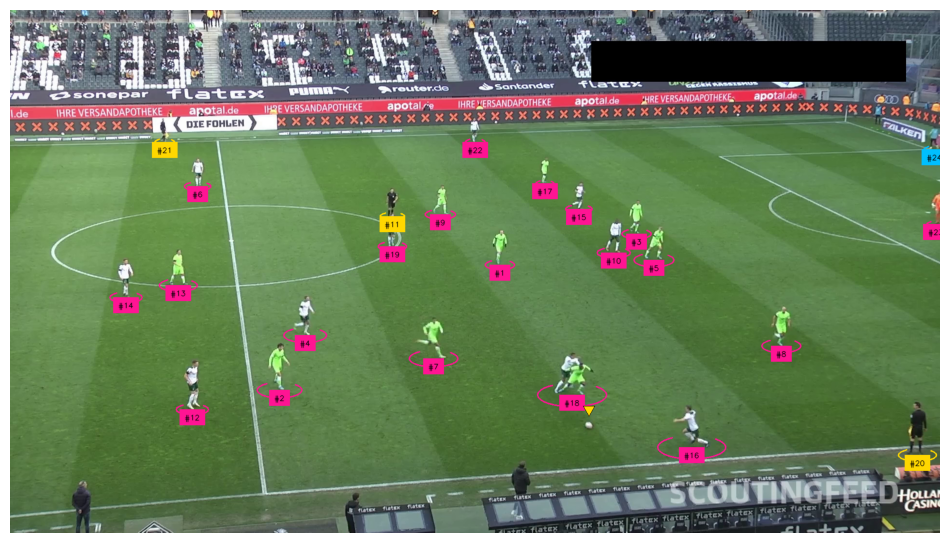

In [26]:
#Tracking IDs
BALL_ID = 0

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1 # remove ball class id
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [27]:
#Split teams
#use of the SigLIP, UMAP, and KMeans combo
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

PLAYER_ID = 2
STRIDE = 60
frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE
)

crops = []
for frame in tqdm(frame_generator, desc="collecting crops"):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    
    # Skip the frame if no players are detected
    if len(players_detections.xyxy) == 0:
        continue
    
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    crops += players_crops

# Ensure there are enough crops for clustering
if len(crops) < 2:
    print("Not enough player crops detected. Skipping team classification.")
else:
    team_classifier = TeamClassifier(device="cpu")
    team_classifier.fit(crops)
    
print(f"Number of players detected: {len(crops)}")

collecting crops: 10it [00:12,  1.26s/it]
Embedding extraction: 7it [00:47,  6.76s/it]


Number of players detected: 198


In [28]:
#GK Assignment - calculate avg centroid of players and assign GK to the team with the closest centroid

import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Embedding extraction: 1it [00:05,  5.23s/it]


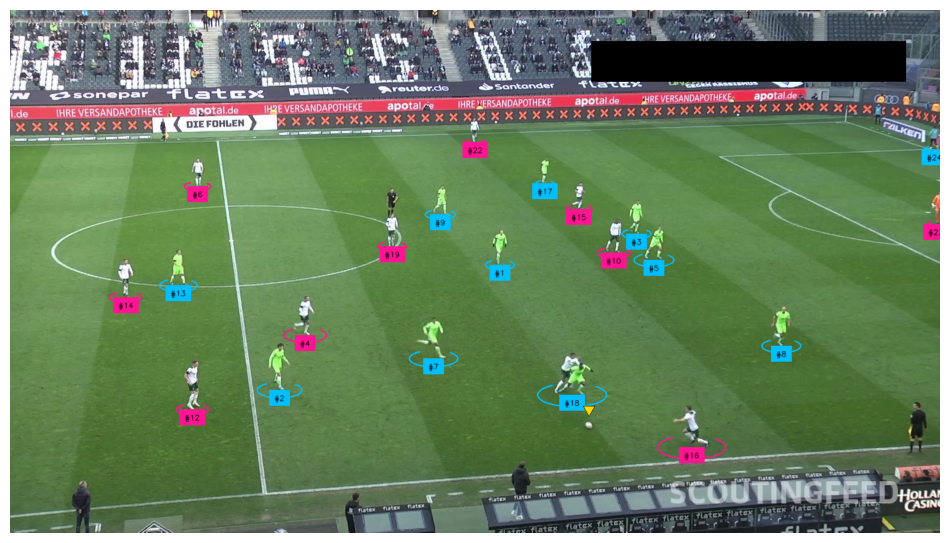

In [29]:
#Tracking with team assignment and gk assignment

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

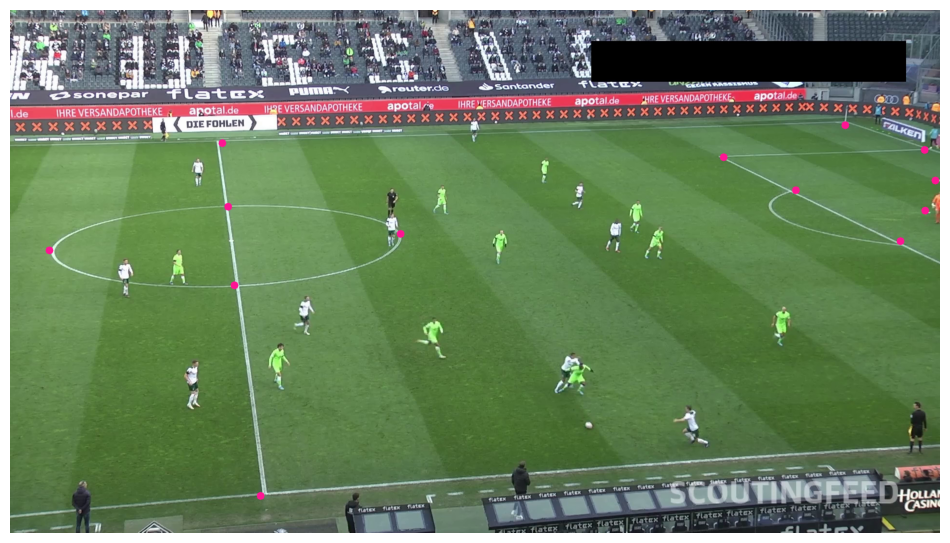

In [30]:
#Pitch Keypoint Detection
from inference import get_model

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

import supervision as sv

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [31]:
#import field
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

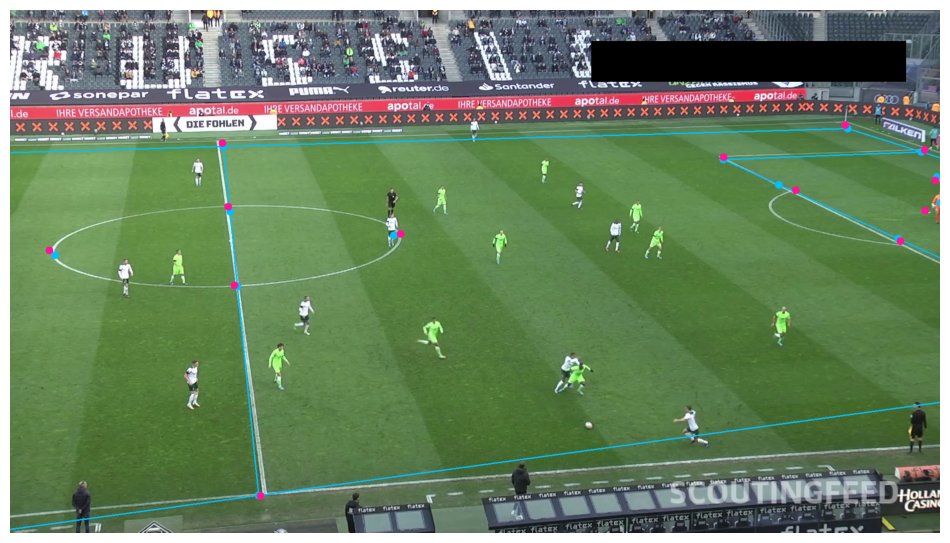

In [32]:
#project points and lines into the frame
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# Filter keypoints based on confidence
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

# Ensure there are at least 4 points for homography calculation
if len(frame_reference_points) < 4 or len(pitch_reference_points) < 4:
    print(f"Skipping frame {frame_index} due to insufficient keypoints: {len(frame_reference_points)} found.")
    
transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

In [33]:
import cv2
from tqdm import tqdm

frames = []

# Use OpenCV to get FPS
video = cv2.VideoCapture(SOURCE_VIDEO_PATH)
fps = video.get(cv2.CAP_PROP_FPS)
video.release()

if not fps or fps <= 0:
    raise ValueError("Could not determine FPS of the video. Please check the video file.")

for frame_index, frame in enumerate(tqdm(sv.get_video_frames_generator(SOURCE_VIDEO_PATH), desc="Processing...")):
    if frame_index % int(fps) == 0: 
        frames.append(frame)

print(f"Total frames collected: {len(frames)}")

Processing...: 600it [00:04, 126.45it/s]


Total frames collected: 20


In [34]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch
)

pitch_frames = []
virt_frames = []

ball_coords = []
gk_t1_coords = []
gk_t2_coords = []

player_coords_per_id = dict()

# Tracker
tracker = sv.ByteTrack()

for frame_index, frame in enumerate(tqdm(frames, desc="Processing...")):
    tqdm.write(f"Frame {frame_index}")

    # ball, goalkeeper, player, referee detection
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    # Save ball coordinates
    if len(ball_detections.xyxy) > 0:
        x_min, y_min, x_max, y_max = ball_detections.xyxy[0]  # Assuming one ball per frame
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        ball_coords.append((frame_index, x_center, y_center))
    else:
        ball_coords.append((frame_index, None, None))  # No ball detected in this frame

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]

    # team assignment
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)
    
    # Save player coordinates per ID
    for xyxy, tracker_id, class_id in zip(
        all_detections.xyxy, all_detections.tracker_id, all_detections.class_id
    ):
        x_min, y_min, x_max, y_max = xyxy
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        if tracker_id is not None:
            if tracker_id not in player_coords_per_id:
                player_coords_per_id[tracker_id] = []
            player_coords_per_id[tracker_id].append((frame_index, x_center, y_center))

    
    # Save goalkeeper coordinates for each team
    for gk, team_id in zip(goalkeepers_detections.xyxy, goalkeepers_detections.class_id):
        x_min, y_min, x_max, y_max = gk
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        if team_id == 0:
            gk_t1_coords.append((frame_index, x_center, y_center))
        elif team_id == 1:
            gk_t2_coords.append((frame_index, x_center, y_center))
    
    all_detections = sv.Detections.merge([players_detections, goalkeepers_detections])

    # frame visualization
    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)

    pitch_frames.append(annotated_frame.copy())
    
    players_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections
    ])

    # detect pitch key points
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)
    
    # Ensure key_points is not None and contains valid data
    if key_points is None or key_points.confidence is None:
        print(f"Skipping frame {frame_index} due to missing key points.")
        continue  # Skip this frame and move to the next one

    # project ball, players and gk on pitch
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    # Ensure there are at least 4 points for homography calculation
    if len(frame_reference_points) < 4 or len(pitch_reference_points) < 4:
        print(f"Skipping frame due to insufficient keypoints: {len(frame_reference_points)} found.")
        continue  # Skip this frame and move to the next one

    # Proceed with homography calculation
    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_players_xy = transformer.transform_points(points=players_xy)

    # visualize video game-style radar view
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy[players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame)

    virt_frames.append(annotated_frame.copy())  
    
    tracker.reset() 

Frame 0


Processing...:   0%|          | 0/20 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.36s/it]


Frame 1


Processing...:   5%|▌         | 1/20 [00:08<02:34,  8.13s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.01s/it]


Frame 2


Processing...:  10%|█         | 2/20 [00:15<02:23,  7.97s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.73s/it]


Frame 3


Processing...:  15%|█▌        | 3/20 [00:23<02:08,  7.58s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.19s/it]


Frame 4


Processing...:  20%|██        | 4/20 [00:30<02:02,  7.65s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.60s/it]


Frame 5


Processing...:  25%|██▌       | 5/20 [00:37<01:51,  7.45s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.49s/it]


Frame 6


Processing...:  30%|███       | 6/20 [00:44<01:42,  7.29s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.21s/it]


Frame 7


Processing...:  35%|███▌      | 7/20 [00:52<01:37,  7.49s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.89s/it]


Frame 8


Processing...:  40%|████      | 8/20 [01:00<01:29,  7.45s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.72s/it]


Frame 9


Processing...:  45%|████▌     | 9/20 [01:07<01:21,  7.40s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.75s/it]


Frame 10


Processing...:  50%|█████     | 10/20 [01:14<01:13,  7.37s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.78s/it]


Frame 11


Processing...:  55%|█████▌    | 11/20 [01:22<01:06,  7.34s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.49s/it]


Frame 12


Processing...:  60%|██████    | 12/20 [01:29<00:58,  7.29s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.63s/it]


Frame 13


Processing...:  65%|██████▌   | 13/20 [01:36<00:50,  7.24s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.94s/it]


Frame 14


Processing...:  70%|███████   | 14/20 [01:43<00:43,  7.30s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.88s/it]


Frame 15


Processing...:  75%|███████▌  | 15/20 [01:52<00:39,  7.83s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.52s/it]


Frame 16


Processing...:  80%|████████  | 16/20 [02:01<00:32,  8.07s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.59s/it]


Frame 17


Processing...:  85%|████████▌ | 17/20 [02:08<00:23,  7.86s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.78s/it]


Frame 18


Processing...:  90%|█████████ | 18/20 [02:16<00:15,  7.70s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:05,  5.80s/it]


Frame 19


Processing...:  95%|█████████▌| 19/20 [02:24<00:08,  8.02s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:04,  4.95s/it]
Processing...: 100%|██████████| 20/20 [02:32<00:00,  7.63s/it]


In [35]:
import cv2
import numpy as np
frames_len = len(frames)

output_dir = f"../../data/frames/old10s-{frames_len}f"
os.makedirs(output_dir, exist_ok=True)

for idx, frame in enumerate(pitch_frames):
    frame_path = os.path.join(output_dir, f"frame_{idx:04d}.png")
    
    cv2.imwrite(frame_path,np.array(frame))

In [36]:
import csv
import numpy as np

output_csv_path = f"../../data/coords/old10s-{frames_len}f.csv"
all_ids = sorted(player_coords_per_id.keys())

# Build lookups
frame_lookup = {}
for tracker_id, coords in player_coords_per_id.items():
    for frame_index, x, y in coords:
        if frame_index not in frame_lookup:
            frame_lookup[frame_index] = {}
        frame_lookup[frame_index][tracker_id] = [x, y]

ball_lookup = {f: [x, y] for f, x, y in ball_coords}
gk0_lookup = {f: [x, y] for f, x, y in gk_t1_coords}
gk1_lookup = {f: [x, y] for f, x, y in gk_t2_coords}

header = (
    ["frame_index", "ball", "gk0", "gk1"] +
    [f"id_{id}" for id in all_ids]
)

all_frames = sorted(set(
    list(frame_lookup.keys()) +
    list(ball_lookup.keys()) +
    list(gk0_lookup.keys()) +
    list(gk1_lookup.keys())
))

with open(output_csv_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for frame_index in all_frames:
        row = [frame_index]
        # Ball
        ball = ball_lookup.get(frame_index, None)
        row.append(f"[{ball[0]},{ball[1]}]" if ball and None not in ball else "")
        # GK team 0
        gk0 = gk0_lookup.get(frame_index, None)
        row.append(f"[{gk0[0]},{gk0[1]}]" if gk0 and None not in gk0 else "")
        # GK team 1
        gk1 = gk1_lookup.get(frame_index, None)
        row.append(f"[{gk1[0]},{gk1[1]}]" if gk1 and None not in gk1 else "")
        # Players by id
        for id in all_ids:
            coord = frame_lookup.get(frame_index, {}).get(id, None)
            row.append(f"[{coord[0]};{coord[1]}]" if coord and None not in coord else "")
        writer.writerow(row)

print(f"Coordinates per frame saved to {output_csv_path}")

Coordinates per frame saved to ../../data/coords/old10s-20f.csv
